In [1]:
from classy import Class
#%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6
'''plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['legend.edgecolor'] = '0.0'
plt.rcParams['figure.figsize'] = 5,5
plt.rcParams.update({'figure.autolayout': False})
plt.rc('text', usetex=False)'''
green1='#238E68'
green2='#32CC99' 
green3='#76EEC6'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'
%load_ext autoreload
%autoreload 2

In [2]:
import swyft
from copy import deepcopy

In [369]:
from getdist import plots, MCSamples
import getdist

In [4]:
#fpr=np.loadtxt("../fake_planck_realistic.dat")

In [4]:
fpr2=np.loadtxt("noise_fake_planck_realistic_two.dat")

Define the simulator and noise model! The true noise model is a $\chi^2$ distribution with $\ell+1$ degrees of freedom. Since simulating this is expensive at large $\ell$, we use a Gaussian approximation starting at $\ell=51$. Note also that to call the noise model, it is efficient to sample the Gaussian noise ahead of time and store it in memory.

In [293]:
lmax=2500
fsky=0.6
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)
#detector contribution to signal, from file
Nltt=fpr2[ell-2,1]
Nlee=fpr2[ell-2,2]

def simulator(v,sigma=0.1): 
    omega_b, omega_cdm, theta, lnAs,n_s,tau_reio=v[0],v[1],v[2],v[3],v[4],v[5]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        #'ln10^{10}A_s': lnAs,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the code.
    cosmo.compute(['lensing'])
    # Extract observables.
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt, TE=cls['te'][ell]*(T*1.e6)**2,\
            EE=cls['ee'][ell]*(T*1.e6)**2+Nlee)



#noise from cosmic variance
#before calling this function, need to generate noisevecs
def noise(obs, params=None, sigma=1.0):
    cat=np.concatenate((obs['TT'],obs['EE'],obs['TE']),axis=0)
    CLTT=[]
    CLEE=[]
    CLTE=[]
    #TODO: need to modify degrees at low ell of freedom using fsky
    for l in range(2,2+49):
    #for l in range(2,2501):
        #g1=np.random.randn(2*l+1)
        #g2=np.random.randn(2*l+1)
        #almT=np.sqrt(obs['TT'][l-2])*g1
        #almE=(obs['TE'][l-2]/np.sqrt(obs['TT'][l-2]))*g1+np.sqrt(obs['EE'][l-2]-obs['TE'][l-2]**2 / obs['TT'][l-2])*g2
        #print(almT.shape, almE.shape)
        #CLTT.append((((2*l+1))**-1 *np.sum((almT**2))))#*np.array([1]+[2]*l)))))
        #CLEE.append((((2*l+1))**-1 *np.sum((almE**2))))#*np.array([1]+[2]*l)))))
        #CLTE.append((((2*l+1))**-1 *np.sum((almT*almE))))#*np.array([1]+[2]*l)))))
        #below is modified d.o.f. version
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        g2=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        almE=(obs['TE'][l-2]/np.sqrt(obs['TT'][l-2]))*g1+np.sqrt(obs['EE'][l-2]-obs['TE'][l-2]**2 / obs['TT'][l-2])*g2
        #print(almT.shape, almE.shape)
        CLTT.append((((nm))**-1 *np.sum((almT**2))))#*np.array([1]+[2]*l)))))
        CLEE.append((((nm))**-1 *np.sum((almE**2))))#*np.array([1]+[2]*l)))))
        CLTE.append((((nm))**-1 *np.sum((almT*almE))))#*np.array([1]+[2]*l)))))
        
    NN=noisevecs[np.random.randint(0,50000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499], np.zeros(29+20), NN[2528+20:4998], np.zeros(29+20),
                         NN[5027+20:]))
    #noise=NN
    cat[:49]=np.array(CLTT)
    cat[2499:2499+49]=np.array(CLEE)
    cat[4998:4998+49]=np.array(CLTE)
    cat=cat+noise
    return {'TT': cat[:2499],'EE': cat[2499:4998], 'TE': cat[4998:]}
    #return {'TT': np.array(CLTT),'EE': np.array(CLEE), 'TE': np.array(CLTE)}

In [269]:
from scipy.stats import wishart

In [273]:
%%time
for lm2 in range(0,50):
    out=wishart.rvs(2*(lm2+2)+1,
               (2/(2*(lm2+2)+1))*np.block([[TTTT[lm2][lm2],TTEE[lm2][lm2],TTTE[lm2][lm2]],
                         [TTEE[lm2][lm2],EEEE[lm2][lm2],TEEE[lm2][lm2]],
                         [TTTE[lm2][lm2],TEEE[lm2][lm2],TETE[lm2][lm2]]]))

CPU times: user 27.9 ms, sys: 0 ns, total: 27.9 ms
Wall time: 26.4 ms


In [275]:
out

array([[ 8.51217226e-01,  1.90765915e-05,  6.62482969e-04],
       [ 1.90765915e-05,  2.92324095e-08, -1.00129863e-08],
       [ 6.62482969e-04, -1.00129863e-08,  6.86294823e-05]])

In [66]:
%%time
noise(obs)

CPU times: user 8.74 ms, sys: 145 µs, total: 8.89 ms
Wall time: 7.76 ms


{'TT': array([1.17201188e+02, 4.21108349e+02, 3.67941937e+02, ...,
        1.87513306e-02, 1.85847917e-02, 1.89221236e-02]),
 'EE': array([0.02492792, 0.00258017, 0.03090813, ..., 0.06872511, 0.0689007 ,
        0.06742726]),
 'TE': array([ 1.70926339e+00,  4.52201280e-01,  3.33291017e+00, ...,
        -6.51004751e-04, -1.93339193e-04,  1.53255756e-03])}

More explicitly, we have the exact $\chi^2$ model

$$a_{\ell m}^T=\sqrt{C_\ell^{TT}}G_{\ell m}^{(1)}$$
$$a_{\ell m}^E=\frac{C_{l}^{TE}}{C_{l}^{TT}}\sqrt{C_\ell^{TT}}G_{\ell m}^{(1)}+\sqrt{C_l^{EE}-\frac{(C_l^{TE})^2}{C_l^{TT}}}G_{\ell m}^{(2)}$$

We finally have the cosmic variance determination
$$\hat{C}_{l}^{PP'}=\frac{1}{2\ell+1}\left(a_{\ell 0}^P a_{\ell 0}^{P'}+2\sum_{m=1}^\ell a_{\ell m}^{P*}a_{\ell m}^{P'}\right)$$

In a gaussian approximation, the covariance is (cf. 0606227)

$$Cov_l=\frac{2}{(2l+1)f_{sky}}\left(
\begin{matrix}
TTTT&TTEE& TTTE\\
TTEE&EEEE&TEEE\\
TTTE&TEEE&TETE
\end{matrix}
\right)$$

ACTUALLY, FACTOR OF 2 SHOULD BE REMOVED FROM NUMERATOR?!?! BUG SOMEWHERE??

with $$TTTT= (C_l^{TT})^2$$, $$EEEE=(C_l^{EE})^2$$, $$TETE=\frac{1}{2}\left[(C_l^{TE})^2+C_l^{TT}C_l^{EE}\right]$$,
$$TTEE=(C_l^{TE})^2$$, $$TTTE=C_l^{TE}C_l^{TT}$$, $$TEEE=C_l^{TE}C_l^{EE}$$

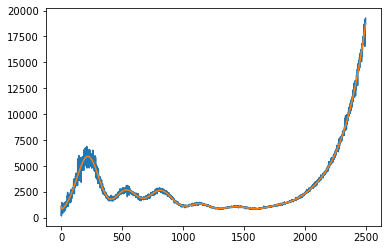

In [264]:
plt.plot(noise(obs)['TT']*ells)
plt.plot(obs['TT']*ells)

In [7]:
#fiducial cosmology
pl=[0.0224, 0.12, 1.0411, 3.0753, 0.965, 0.054]

In [8]:
%%time
obs=simulator(pl)
#obs=noise(model(par))

CPU times: user 8.79 s, sys: 395 ms, total: 9.18 s
Wall time: 1.55 s


check consistency against MCMC cluster

In [9]:
fid=np.loadtxt('fake_planck_realistic_fiducial.dat')

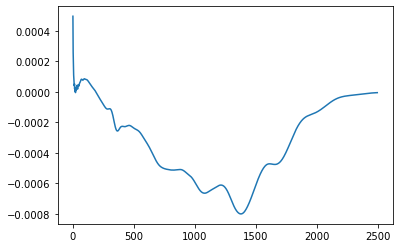

In [10]:
plt.plot((fid[:,1]-obs['TT'])/(obs['TT']))

perform trick of pre-generating noise for fiducial model

In [169]:
lowEllFudge=np.array([fsky]*(29+20)+[1]*(2499-29-20))

In [11]:
TTTT=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
EEEE=np.diag(obs['EE']**2)*2/((2*ell+1)*fsky)
TETE=np.diag(0.5*(obs['TE']**2+obs['TT']*obs['EE']))*2/((2*ell+1)*fsky)
TTEE=np.diag(obs['TE']**2)*2/((2*ell+1)*fsky)
TTTE=np.diag(obs['TE']*obs['TT'])*2/((2*ell+1)*fsky)
TEEE=np.diag(obs['TE']*obs['EE'])*2/((2*ell+1)*fsky)

In [12]:
covmat=np.block([[TTTT,TTEE,TTTE],[TTEE,EEEE,TEEE],[TTTE,TEEE,TETE]])

In [13]:
icovmat=np.linalg.inv(covmat)

In [14]:
csqrt=np.linalg.cholesky(covmat)

In [15]:
%%time
noisevecs=np.random.multivariate_normal(np.zeros(7497),covmat,size=50000)
#noisevecs=[np.dot(csqrt,np.random.randn(7497)) for i in range(50000)]
#noisevecs=np.random.multivariate_normal(np.zeros(5997),covmat,size=50000)

CPU times: user 1h 32min 16s, sys: 38min 43s, total: 2h 10min 59s
Wall time: 4min 26s


now generate reasonable prior using Fisher analysis. Start by defining finite derivative

In [20]:
#use choice of logarithmic noise for low ell bins
def finiteD(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    output=[]
    for kk in ['TT','EE','TE']:
        output.append((m1[kk]-m2[kk])/(pl[k]*(2*eps)))
    return np.ravel(output)

In [21]:
#this is "exact" version of log-likelihood
def chi2(fid, test):
    detTestL=test['TT']*test['EE']-test['TE']**2
    detFidL=fid['TT']*fid['EE']-fid['TE']**2
    #print(test['TT'][0], test['EE'][0], test['TE'][0])
    #print(fid['TT'][0], fid['EE'][0], fid['TE'][0])
    #print(detTestL[0])
    #print(detFidL[0])
    mix=fid['TT']*test['EE']+test['TT']*fid['EE']-2*fid['TE']*test['TE']
    res=np.sum(fsky*(2*ell+1)*(mix/detTestL+np.log(detTestL/detFidL)-2))
    return res
def lnL(fid,test):
    return -0.5*chi2(fid,test)

In [22]:
def finiteD2LNL(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    m0=simulator(pl)
    return (lnL(m0,m1)+lnL(m0,m2)-2*lnL(m0,m0))/(pl[k]*eps)**2

In [23]:
f00=finiteD2LNL(0)

compute derivatives and Fisher matrix

In [24]:
ders=[finiteD(i) for i in range(6)]
#ders=[finiteD(i, epsList[i]) for i in range(6)]

In [25]:
F=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        d1=ders[i]
        if i != j: 
            d2=ders[j]
        else: 
            d2=d1
        term1=np.dot(d1,np.matmul(icovmat,d2))
        #term1=np.dot(d1,np.linalg.solve(covmat,d2))
        #only EE
        #term1=np.sum((d1*d2/SIG**2))#[1999:3998])
        F[i,j]=term1

as a check, the following should be close to 1

In [29]:
-F[0][0]/f00

0.9998582915023737

In [30]:
Finv=np.linalg.inv(F)

In a Fisher (i.e. Gaussian) approximation $\sigma_i$ is given by $\sqrt{(F^{-1})_{ii}}$ 

In [31]:
sigss=[]
for i in range(6): sigss.append(np.sqrt(Finv[i,i]));

In [32]:
sigss

[0.000154187280234718,
 0.0014188712158778338,
 0.0003323774633217167,
 0.008657110635400226,
 0.003970104487095405,
 0.004278009623826205]

check percentage for each parameter. This can be used to tune the Fisher calculation, but it's already pretty good.

In [35]:
epsList=[sigss[i]/pl[i] for i in range(len(pl))]

In [36]:
epsList

[0.006883360724764196,
 0.011823926798981949,
 0.00031925604007464864,
 0.002815045893213744,
 0.0041140979140885025,
 0.07922240044122603]

define uniform prior with $\theta\in [\theta_0-5\sigma,\theta_0+5\sigma]$

In [37]:
def uv(u):
    offsets=np.array(pl)
    scales=np.array([5*sigss[i] for i in range(len(pl))])
    return 2*(u-0.5)*scales+offsets

In [38]:
uv(np.zeros(6)), uv(np.zeros(6)+1)

(array([0.02162906, 0.11290564, 1.03943811, 3.03201445, 0.94514948,
        0.03260995]),
 array([0.02317094, 0.12709436, 1.04276189, 3.11858555, 0.98485052,
        0.07539005]))

In [39]:
prior=swyft.Prior.from_uv(uv, 6)

instantiate various swyft objects

In [89]:
sim=swyft.Simulator(simulator, sim_shapes={'TT':[2499], 'TE':[2499],'EE':[2499]})
#sim=swyft.Simulator(simulator, sim_shapes={'TT':[1999], 'TE':[1999],'EE':[1999]})

In [90]:
#store=swyft.DirectoryStore(list(par.keys()), simulator=sim, path='cacheTTTEEE.zarr')
store=swyft.DirectoryStore(['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio'], simulator=sim, path='/var/scratch/aecole/TTTEEElm2500.zarr')

DEBUG:root:  params = ['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s', 'n_s', 'tau_reio']
INFO:root:Creating new store.
DEBUG:root:  sim_shapes = {'TT': [2499], 'TE': [2499], 'EE': [2499]}


define head network. Some care should be taken for the low-$\ell$ $\chi^2$ bins

In [253]:
Tnoise=np.array([noise(obs)['TT'] for i in range(10000)])

In [325]:
Enoise=np.array([noise(obs)['EE'] for i in range(10000)])

Let's look at many samples of the noise for a low-$\ell$ bin.

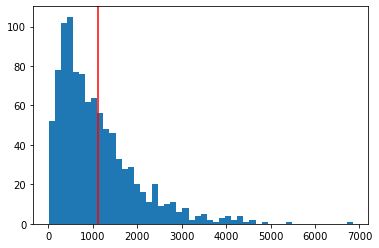

In [244]:
plt.hist(Enoise[:,0], bins=50);
plt.axvline(obs['EE'][0],c='red');

it sometimes is a good idea to take the square root (recall definition of $\chi^2$ distribution

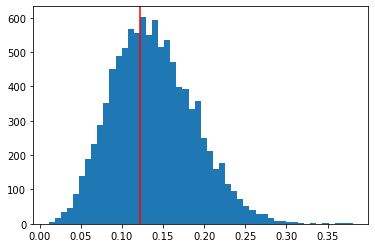

In [327]:
i=1
l=i+2
#ng=int(np.round(fsky*(l+1)))
#nm=1+2*(ng-1)
nm=fsky*(2*l+1)
plt.hist(np.sqrt(Enoise[:,i]), bins=50);
#plt.axvline(np.sqrt(obs['TT'][0]),c='red');
plt.axvline(np.sqrt(obs['EE'][i])*np.sqrt((nm-1)/(nm-2))**-1,c='red')

this is not quite unbiased (the line does not go through the maximum). In fact, this is due to a Jacobian factor in going from $\chi^2\to \sqrt{\chi^2}$. We can fix this by modifying the weights

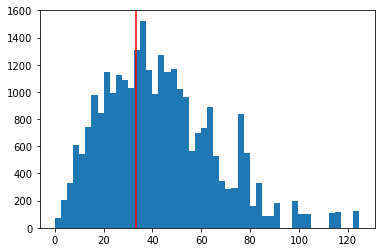

In [45]:
plt.hist(np.sqrt(Tnoise[:,0]), bins=50, weights=np.sqrt(Tnoise[:,0]));
plt.axvline(np.sqrt(obs['TT'][0]),c='red');

but since such an effect (working with the measure) is difficult to incorporate into the head network. Can alternatively try rescaling.

peak at $k-2$ for $\chi^2$ vs $k$ for $\sqrt{\chi^2}$, with $k$ degrees of freedom. Here $k=2\ell+1$. The counting is a bit tricky, but I believe this is correct. See 0604547, the ML estimator has a gamma distribution. Eqn. (6)

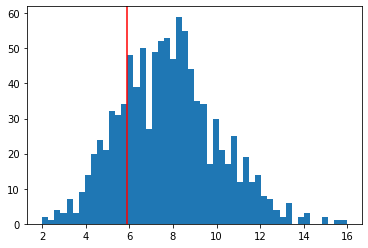

In [55]:
plt.hist(np.sqrt(Tnoise[:,10]), bins=50);
plt.axvline(np.sqrt(obs['TT'][10]),c='red');

looks good. for fun let's check another bin.

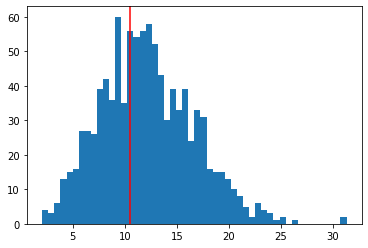

In [52]:
plt.hist(np.sqrt(Tnoise[:,5]), bins=50);
plt.axvline(np.sqrt(obs['TT'][5]*((2*7*fsky-1)/(2*7*fsky))**-1),c='red');

This is all to say that it is perhaps useful to (1) apply a square root to the low-$\ell$ bins (2) rescale the Asimov data to live at the peak of the noise model.

In [179]:
from swyft.networks import OnlineNormalizationLayer
import torch.nn.functional as F
class HeadLow(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 10
        #self.l = torch.nn.Linear(7497-58, 10)
        self.l = torch.nn.Linear(7497, 10)
        #self.l2 = torch.nn.Linear(58,5)
        self.onl_f = OnlineNormalizationLayer(torch.Size([7497]))
        #self.onl_f2 = OnlineNormalizationLayer(torch.Size([58]))
        #self.Ells = torch.tensor(ells, dtype=torch.float32).to('cuda')

    def forward(self, obs):
        x = torch.cat((obs['TT'][:,49:], obs['EE'][:,49:], obs['TE']), axis=1)
        x1 = torch.sqrt(torch.cat((obs['TT'][:,:49],
                        obs['EE'][:,:49]), axis=1))
        x=torch.cat((x,x1),axis=1)
        #x1=torch.sqrt(x1)
        x=self.onl_f(x)
        #x1=self.onl_f2(x1)
        nbatch = len(obs)
        x = self.l(x)
        #x1=self.l2(x1)

        #return torch.cat((x,x1),axis=1)
        return x

DEBUG:root:Registering new swyft.Module with tag `HeadLow`


In [278]:
from swyft.networks import OnlineNormalizationLayer
import torch.nn.functional as F
class HeadLow(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 15
        #self.l = torch.nn.Linear(7497-58, 10)
        self.l = torch.nn.Linear(7497, 10)
        self.l2 = torch.nn.Linear(98,5)
        self.onl_f = OnlineNormalizationLayer(torch.Size([7497]))
        self.onl_f2 = OnlineNormalizationLayer(torch.Size([98]))
        #self.Ells = torch.tensor(ells, dtype=torch.float32).to('cuda')

    def forward(self, obs):
        x = torch.cat((obs['TT'][:,49:], obs['EE'][:,49:], obs['TE']), axis=1)
        x1 = torch.sqrt(torch.cat((obs['TT'][:,:49],
                        obs['EE'][:,:49]), axis=1))
        x=torch.cat((x,x1),axis=1)
        x1=torch.sqrt(x1)
        x=self.onl_f(x)
        x1=self.onl_f2(x1)
        nbatch = len(obs)
        x = self.l(x)
        x1=self.l2(x1)

        return torch.cat((x,x1),axis=1)
        #return x

DEBUG:root:Registering new swyft.Module with tag `HeadLow`


We can also compare to a simple linear compression head.

In [224]:
from swyft.networks import OnlineNormalizationLayer
class HeadLinear(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 20
        self.l = torch.nn.Linear(7497, 20)
        self.onl_f = OnlineNormalizationLayer(torch.Size([7497]))

    def forward(self, obs):
        x = torch.cat((obs["TT"], obs['EE'],obs['TE']), axis=1)
        x=self.onl_f(x)

        x = self.l(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `HeadLinear`


In [58]:
partitions=[i for i in range(len(pl))]

In [59]:
from dask.diagnostics import ProgressBar

In [60]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [294]:
with ProgressBar():    
    dataset = swyft.Dataset(5000, prior, simhook = noise, store = store)
    dataset.simulate()

DEBUG:root:Cache locked
DEBUG:root:Cache unlocked
DEBUG:root:No simulations required.


In [295]:
post = swyft.Posteriors(dataset)

start by checking 1-dimensional marginals

In [331]:
post.infer([0,1,2,3,4,5], device = 'cuda', head = HeadLow,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLow`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'TT': torch.Size([2499]), 'EE': torch.Size([2499]), 'TE': torch.Size([2499])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(15, [(0,), (1,), (2,), (3,), (4,), (5,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 6.483
DEBUG:root:validation loss = 5.965
DEBUG:root:validation loss = 5.706
DEBUG:root:validation loss = 5.553
DEBUG:root:validation loss = 5.386
DEBUG:root:validation loss = 5.448
DEBUG:ro

now do a rescaling at low $\ell$ (?) for Asimov data. This rescaling uses knowledge of the `torch.sqrt` operation in the Head layer, I believe that without `torch.sqrt` one would replace `nm-1`-> `nm` in the numerator. Perhaps it's worth checking.

In [337]:
llow=ell[:49]
obs2=deepcopy(obs)
for i in range(49):
    l=i+2
    nm=np.round(fsky*(2*l+1))
    #obs2['TT'][i]*=((2*l+1)/(2*l-1))
    #obs2['EE'][i]*=((2*l+1)/(2*l-1))
    obs2['TT'][i]*=((nm-1)/(nm-2))**-0.5
    obs2['EE'][i]*=((nm-1)/(nm-2))**-0.5

In [259]:
#sampSW=post.sample(50000,obs)

In [338]:
sampSW=post.sample(50000,obs2)

plot some stuff

In [134]:
#rescaling to see agreement with Fisher
#sampSW['params']=(sampSW['params']-np.array(pl).reshape(1,6))*(1/np.array(sigss))
#sampSW['params'][:,3]=(sampSW['params'][:,3]-np.average(sampSW['params'][:,3], weights=sampSW['weights'][(3,)]))
#sampSW['params'][:,5]=(sampSW['params'][:,5]-np.average(sampSW['params'][:,5], weights=sampSW['weights'][(5,)]))

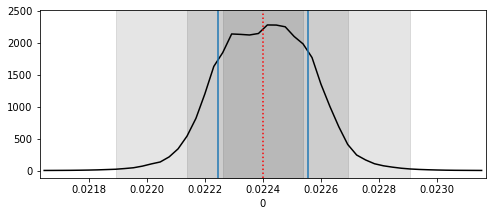

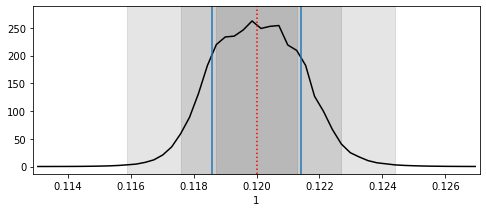

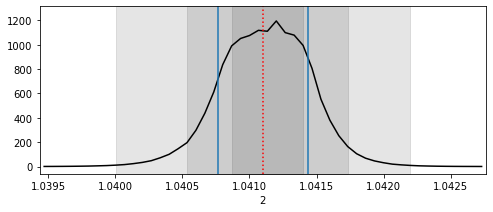

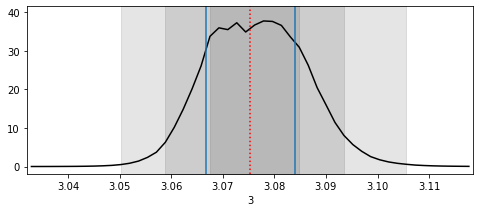

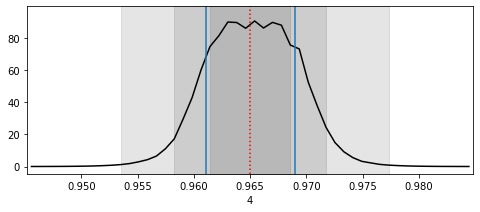

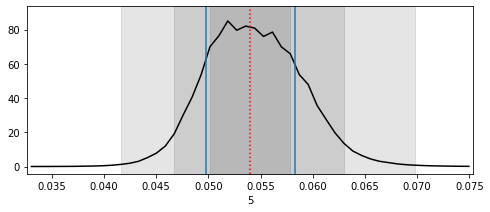

In [339]:
for i in range(6):
    swyft.plot1d(sampSW, [i],truth=pl,figsize=(8,3), bins=50,ncol=1)
    plt.axvline(pl[i]+sigss[i])
    plt.axvline(pl[i]-sigss[i])

In [237]:
names=['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio']

plot more smoothly

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


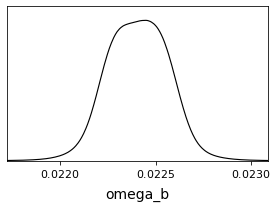

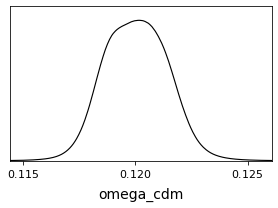

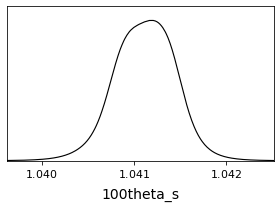

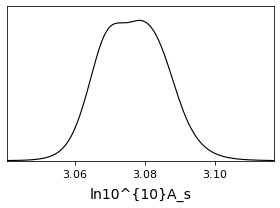

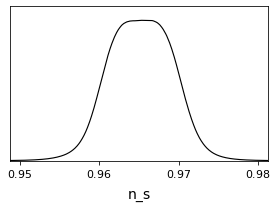

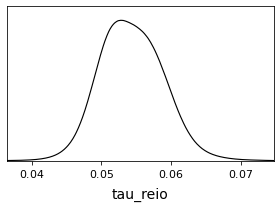

In [340]:
logger.setLevel(logging.INFO)
constr=[]
for j in [0,1,2,3,4,5]:
    #samMCMC = MCSamples(samples=samps, names=["x%s"%i for i in [0,1,2,3,4,5]])
    #samMCMC.removeBurnFraction(0.05)
    samSWYFT= MCSamples(samples=sampSW['params'], names=names, weights=sampSW['weights'][(j,)])
    #, weights=np.array([samples['weights'][(0,)]]))
    constr.append((samSWYFT.getInlineLatex(names[j],limit=1)))#,samMCMC.getInlineLatex(names[j],limit=1)))
    g = plots.get_single_plotter(width_inch=4)
    g.plot_1d([samSWYFT], names[j], normalized=False)
    #plt.axvline(0)
    #plt.xticks([-3,-2,-1,0,1,2,3])
logger.setLevel(logging.DEBUG)

In [341]:
for elm in constr:
    print(elm)
print(sigss)

omega_b = 0.02241\pm 0.00016
omega_cdm = 0.1200\pm 0.0014
100theta_s = 1.04112\pm 0.00033
ln10^{10}A_s = 3.0766^{+0.0091}_{-0.010}
n_s = 0.9652\pm 0.0039
tau_reio = 0.0543^{+0.0042}_{-0.0048}
[0.000154187280234718, 0.0014188712158778338, 0.0003323774633217167, 0.008657110635400226, 0.003970104487095405, 0.004278009623826205]


In [342]:
pl

[0.0224, 0.12, 1.0411, 3.0753, 0.965, 0.054]

Looks good, now we can try for a corner plot

In [343]:
post.infer(swyft.utils.parameters._corner_params(partitions), device = 'cuda', head = HeadLow,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLow`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'TT': torch.Size([2499]), 'EE': torch.Size([2499]), 'TE': torch.Size([2499])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(15, [(0,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1,), (1, 2), (1, 3), (1, 4), (1, 5), (2,), (2, 3), (2, 4), (2, 5), (3,), (3, 4), (3, 5), (4,), (4, 5), (5,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 18.89
DEBUG:root:validation loss = 16.49
DEBUG:root:validation loss =

In [394]:
samples=post.sample(200000,obs2)

In [153]:
#samples['params']=(samples['params']-np.array(pl).reshape(1,6))*(1/np.array(sigss))

In [147]:
#(OPTIONAL)do some stuff to shift to weighted mean=0 for tau and A_s
#samples['params'][:,3]=(samples['params'][:,3]-np.average(samples['params'][:,3], weights=samples['weights'][(3,)]))
#samples['params'][:,5]=(samples['params'][:,5]-np.average(samples['params'][:,5], weights=samples['weights'][(5,)]))


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=22.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 

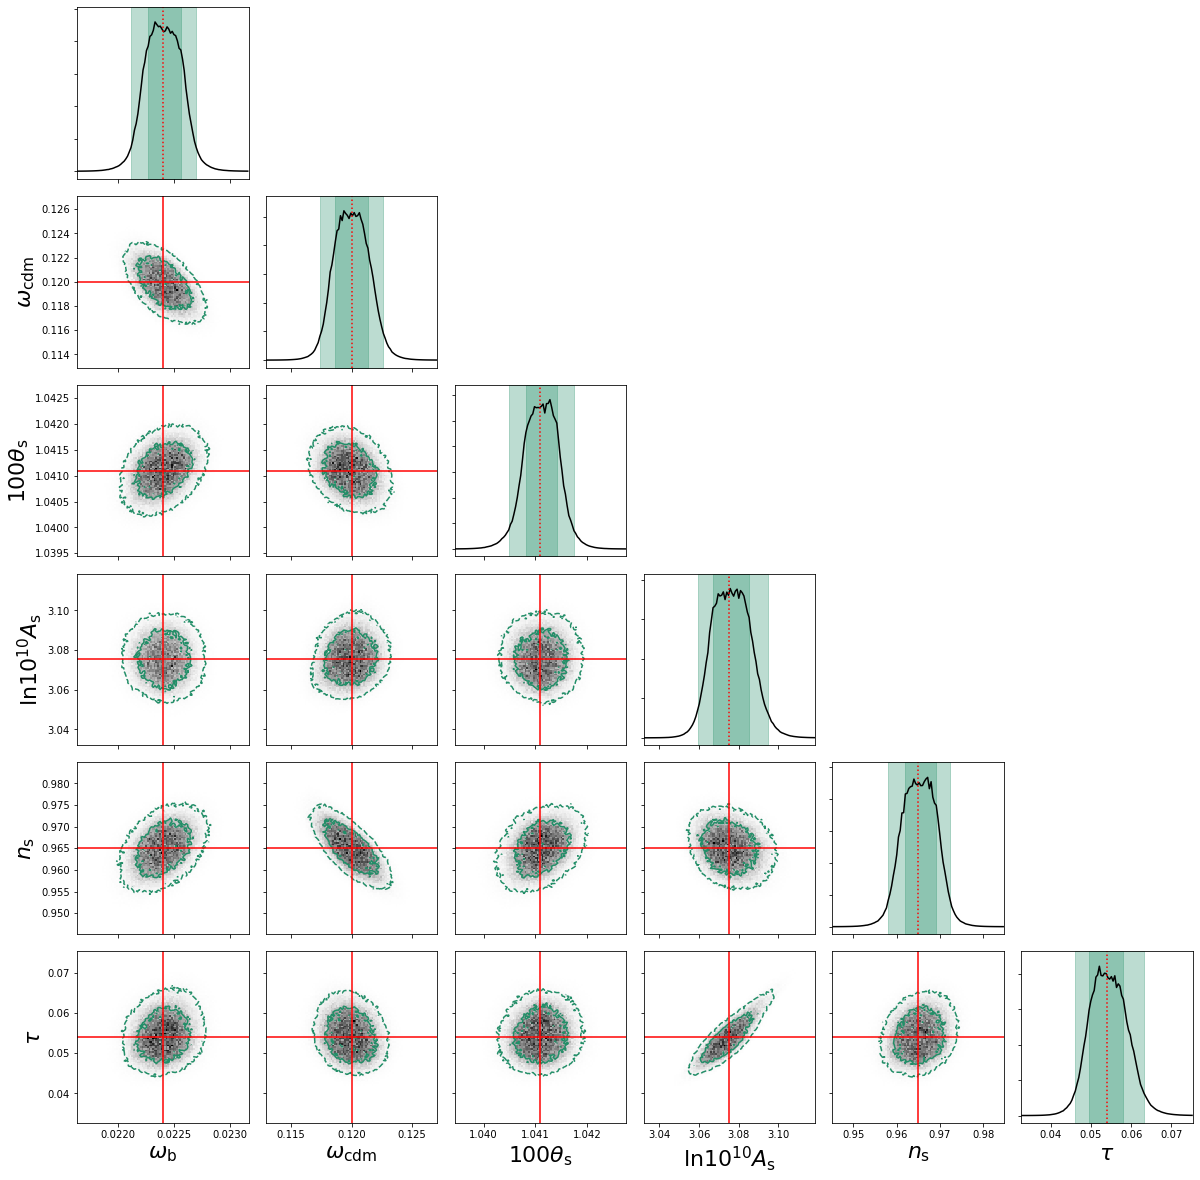

In [349]:
logger.setLevel(logging.INFO)
corner(samples, list(range(6)), Finv, truth=pl, bins=100, figsize=(20,20),
      labels=['$\omega_{\\rm b}$', '$\omega_{\\rm cdm}$', '$100\\theta_{\\rm s}$', '$\ln10^{10}A_{\\rm s}$', '$n_{\\rm s}$', '$\\tau$'],
      label_args={'fontsize': 22},plotF=False)
logger.setLevel(logging.DEBUG)
plt.savefig('toyTTTEEEnoFisher.png')

In [360]:
sd=post.state_dict()

In [361]:
torch.save(sd, "CMB_TTTEEE_posteriorMay5.pt")

custom plotting functions

In [392]:
def corner(
    samples,
    params,
    FFinv,
    figsize=(10, 10),
    color="k",
    labels=None,
    label_args={},
    truth=None,
    bins=100,
    plotF=False
) -> None:
    K = len(params)
    fig, axes = plt.subplots(K, K, figsize=figsize)
    fig.set_facecolor('w')
    lb = 0.125
    tr = 0.9
    whspace = 0.1
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = [params[i] for i in range(K)]
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            # Switch off upper left triangle
            if i < j:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                continue

            # Formatting labels
            if j > 0 or i == 0:
                ax.set_yticklabels([])
                # ax.set_yticks([])
            if i < K - 1:
                ax.set_xticklabels([])
                # ax.set_xticks([])
            if i == K - 1:
                ax.set_xlabel(labels[j], **label_args)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i], **label_args)

            # Set limits
            # ax.set_xlim(x_lims[j])
            # if i != j:
            #    ax.set_ylim(y_lims[i])

            # 2-dim plots
            if j < i:
                if plotF==True:
                    temp=FFinv[(np.ix_([i,j],[i,j]))]
                    FF=np.linalg.inv(temp)
                    y, x = np.ogrid[-5*sigss[j]:5*sigss[j]:1000j, -5*sigss[i]:5*sigss[i]:1000j]
                    #y, x = np.ogrid[-50*sigs[i]:50*sigs[i]:1000j, -50*sigs[j]:50*sigs[j]:1000j]
                    ax.contour(x.ravel()/sigss[i],y.ravel()/sigss[j],x**2*FF[0,0]+2*x*y*FF[0,1]+y**2*FF[1,1],[2.3],
                              colors='blue');
                    #ax.contour(x.ravel()+pl[i],y.ravel()+pl[j],
                    #           x**2*FF[0,0]**2+2*x*y*FF[0,1]**2+y**2*FF[1,1],
                    #           [2.3],
                    #          colors='blue');
                #swyft.utils.plot.plot_posterior(
                #    samples, [params[j], params[i]], ax=ax, color=color, bins=bins
                #)
                plot_posterior(
                    samples, [params[j], params[i]], ax=ax, color=color, bins=bins
                )
                if truth is not None:
                    ax.axvline(truth[params[j]], color="r")
                    ax.axhline(truth[params[i]], color="r")
            if j == i:
                #swyft.utils.plot.plot_posterior(samples, params[i], ax=ax, color=color, bins=bins)
                plot_posterior(samples, params[i], ax=ax, color=color, bins=bins)
                if truth is not None:
                    ax.axvline(truth[params[i]], ls=":", color="r")


In [347]:
from swyft.utils.plot import get_contour_levels
def plot_posterior(
    samples,
    params,
    weights_key=None,
    ax=plt,
    grid_interpolate=False,
    bins=100,
    color="k",
    **kwargs
):
    if isinstance(params, int):
        params = (params,)

    w = None

    # FIXME: Clean up ad hoc code
    if weights_key is None:
        weights_key = tuple(sorted(params))
    try:
        w = samples["weights"][tuple(weights_key)]
    except KeyError:
        if len(weights_key) == 1:
            for k in samples["weights"].keys():
                if weights_key[0] in k:
                    weights_key = k
                    break
            w = samples["weights"][tuple(weights_key)]
        elif len(weights_key) == 2:
            for k in samples["weights"].keys():
                if set(weights_key).issubset(k):
                    weights_key = k
                    w = samples["weights"][k]
    if w is None:
        return

    if len(params) == 1:
        x = samples["params"][:, params[0]]

        if grid_interpolate:
            # Grid interpolate samples
            log_prior = samples["log_priors"][params[0]]
            w_eff = np.exp(np.log(w) + log_prior)  # p(z|x) = r(x, z) p(z)
            zm, v = grid_interpolate_samples(x, w_eff)
        else:
            v, e = np.histogram(x, weights=w, bins=bins, density=True)
            zm = (e[1:] + e[:-1]) / 2

        levels = sorted(get_contour_levels(v,cred_level=[0.68268, 0.95450]))
        contour1d(zm, v, levels, ax=ax, color=color)
        ax.plot(zm, v, color=color, **kwargs)
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([-v.max() * 0.05, v.max() * 1.1])
    elif len(params) == 2:
        # FIXME: use interpolation when grid_interpolate == True
        x = samples["params"][:, params[0]]
        y = samples["params"][:, params[1]]
        counts, xbins, ybins, _ = ax.hist2d(x, y, weights=w, bins=bins, cmap="gray_r")
        levels = sorted(get_contour_levels(counts,cred_level=[0.68268, 0.95450]))
        try:
            ax.contour(
                counts.T,
                extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
                levels=levels,
                linestyles=["dashed","solid"],
                colors=green1,
            )
        except ValueError:
            print("WARNING: 2-dim contours not well-defined.")
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([y.min(), y.max()])


In [348]:
def contour1d(z, v, levels, ax=plt, linestyles=None, color=None, **kwargs):
    y0 = -0.05 * v.max()
    y1 = 1.1 * v.max()
    ax.fill_between(z, y0, y1, where=v > levels[0], color=green1, alpha=0.3)
    ax.fill_between(z, y0, y1, where=v > levels[1], color=green1, alpha=0.3)

another plot featuring Fisher matrix

In [395]:
samples2=deepcopy(samples)
samples2['params']=(samples2['params']-np.array(pl).reshape(1,6))*(1/np.array(sigss))

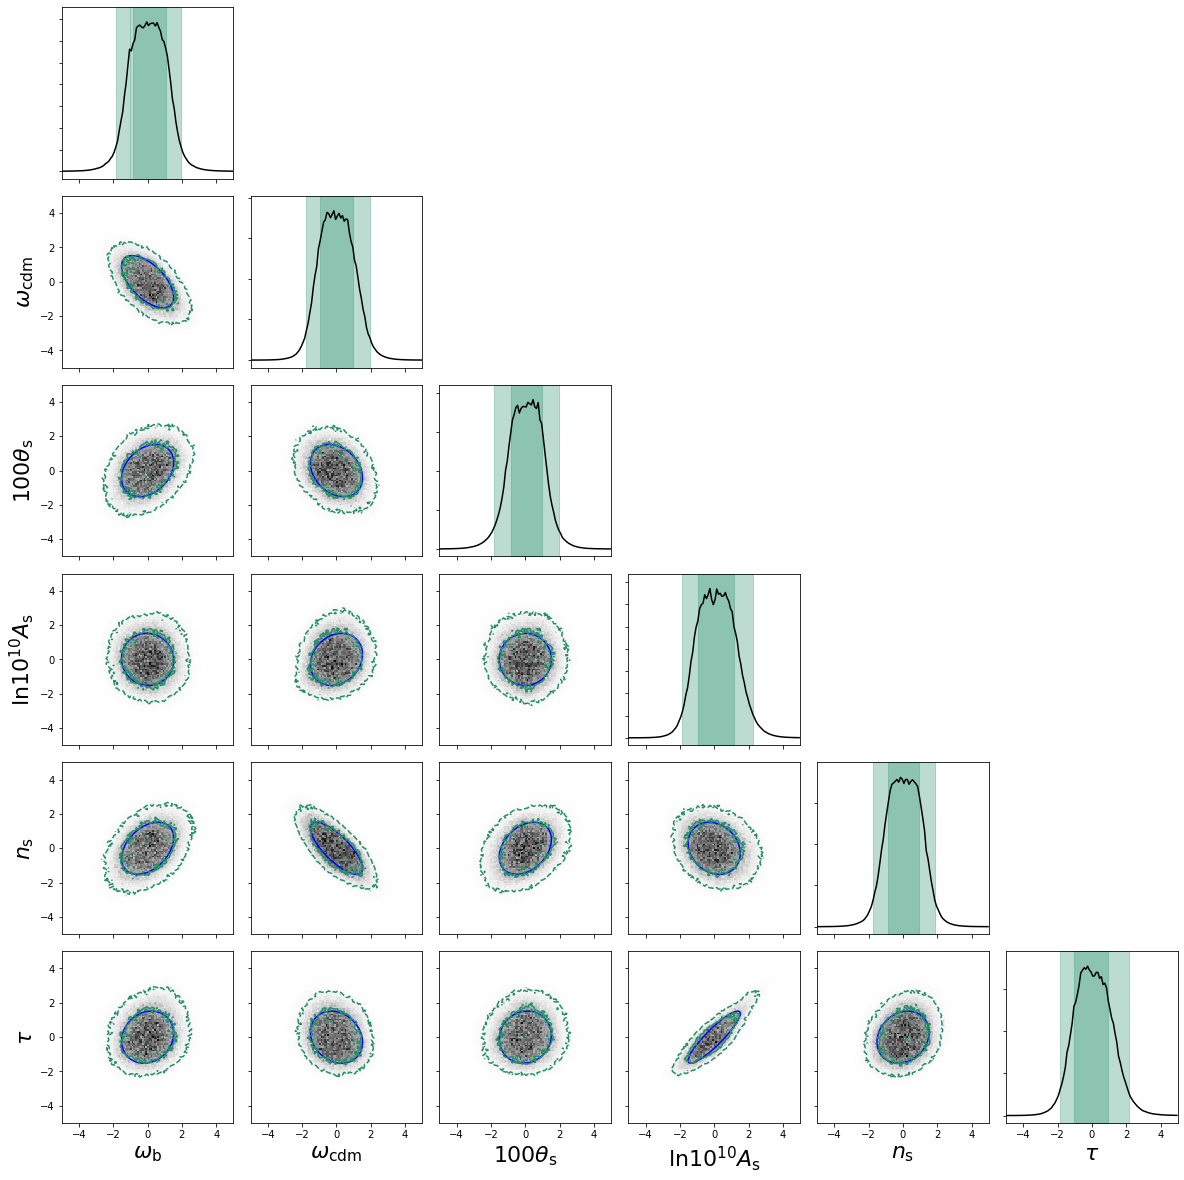

In [396]:
logger.setLevel(logging.INFO)
corner(samples2, list(range(6)), Finv, truth=None, bins=100, figsize=(20,20),
      labels=['$\omega_{\\rm b}$', '$\omega_{\\rm cdm}$', '$100\\theta_{\\rm s}$', '$\ln10^{10}A_{\\rm s}$', '$n_{\\rm s}$', '$\\tau$'],
      label_args={'fontsize': 22},plotF=True)
logger.setLevel(logging.DEBUG)
plt.savefig('toyTTTEEEwFisher.png')

try comparing against MCMC runs

In [368]:
from getdist import loadMCSamples

In [363]:
sampMC=loadMCSamples('chains/2021-05-03_500000_')

In [364]:
samples['params'][:,0]*=100

In [ ]:
2.356262e-08   -1.292990e-07    1.575716e-08   -6.471151e-08    2.423609e-07    8.533347e-08   
-1.292990e-07    2.013330e-06   -1.342815e-07    2.281077e-06   -4.348745e-06   -1.244042e-06   
 1.575716e-08   -1.342815e-07    1.086448e-07   -8.132079e-08    4.411523e-07    6.878634e-08   
-6.471151e-08    2.281077e-06   -8.132079e-08    7.023720e-05   -6.812576e-06    3.134397e-05   
 2.423609e-07   -4.348745e-06    4.411523e-07   -6.812576e-06    1.569106e-05    3.039921e-06   
 8.533347e-08   -1.244042e-06    6.878634e-08    3.134397e-05    3.039921e-06    1.733436e-05 

Removed no burn in
omega_b = 2.241\pm 0.016 10^{-2}\omega{}_{b } = 2.240\pm 0.015
Removed no burn in
omega_cdm = 0.1200\pm 0.0014 \omega{}_{cdm } = 0.1200\pm 0.0014
Removed no burn in
100theta_s = 1.04112\pm 0.00033 100\theta{}_{s } = 1.04111\pm 0.00034
Removed no burn in
ln10^{10}A_s = 3.0766^{+0.0090}_{-0.010} ln10^{10}A_{s } = 3.0765^{+0.0080}_{-0.0097}
Removed no burn in
n_s = 0.9653\pm 0.0039 n_{s } = 0.9651\pm 0.0040
Removed no burn in
tau_reio = 0.0544^{+0.0043}_{-0.0049} \tau{}_{reio } = 0.0547^{+0.0039}_{-0.0048}


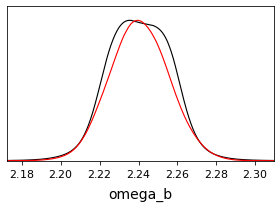

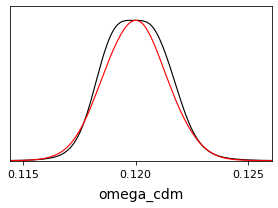

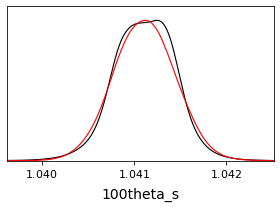

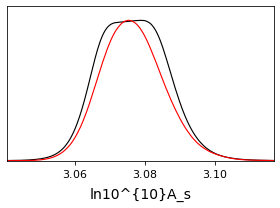

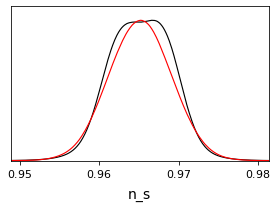

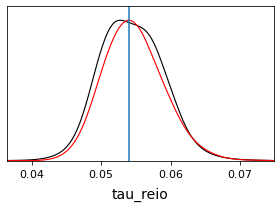

In [365]:
logger.setLevel(logging.INFO)
constr=[]
for j in [0,1,2,3,4,5]:
    samSWYFT= MCSamples(samples=samples['params'], names=names, weights=samples['weights'][(j,)])
    #, weights=np.array([samples['weights'][(0,)]]))
    print(samSWYFT.getInlineLatex(names[j],limit=1),sampMC.getInlineLatex(names[j],limit=1))
    constr.append((samSWYFT.getInlineLatex(names[j],limit=1),sampMC.getInlineLatex(names[j],limit=1)))
    g = plots.get_single_plotter(width_inch=4)
    g.plot_1d([samSWYFT, sampMC], names[j], normalized=False)
    plt.axvline(pl[i])
logger.setLevel(logging.DEBUG)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


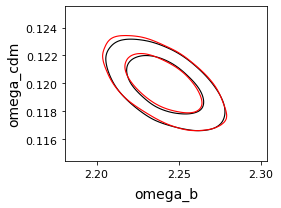

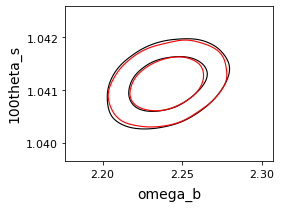

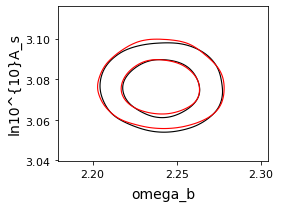

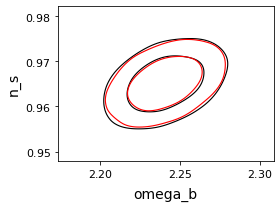

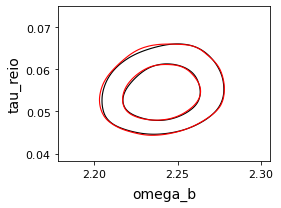

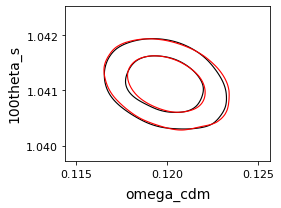

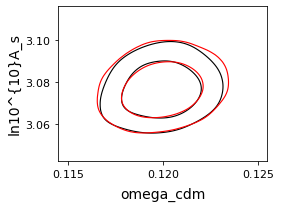

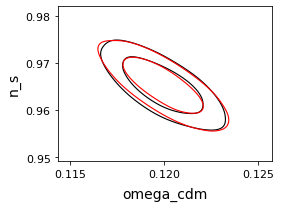

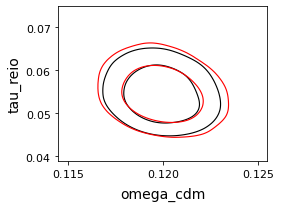

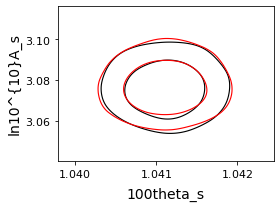

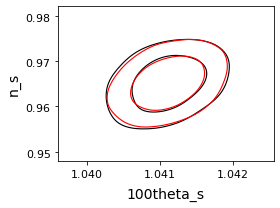

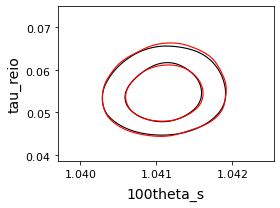

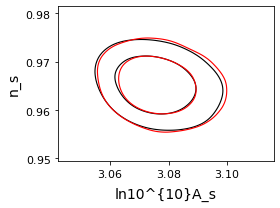

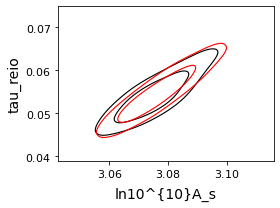

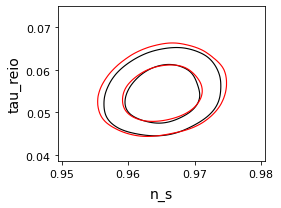

In [370]:
logger.setLevel(logging.INFO)
plts=[]
for j in swyft.utils.parameters._corner_params(partitions):
    if len(j)==2:
        samSWYFT= MCSamples(samples=samples['params'], names=names, weights=samples['weights'][j])
        #, weights=np.array([samples['weights'][(0,)]]))
        g = plots.get_single_plotter(width_inch=4)
        plts.append(g.plot_2d([samSWYFT, sampMC], names[j[0]], names[j[1]]))
logger.setLevel(logging.DEBUG)

In [371]:
plts[0]

((2.180903933275683, 2.3032836633749474),
 (0.11442065651494128, 0.12552587105660148))

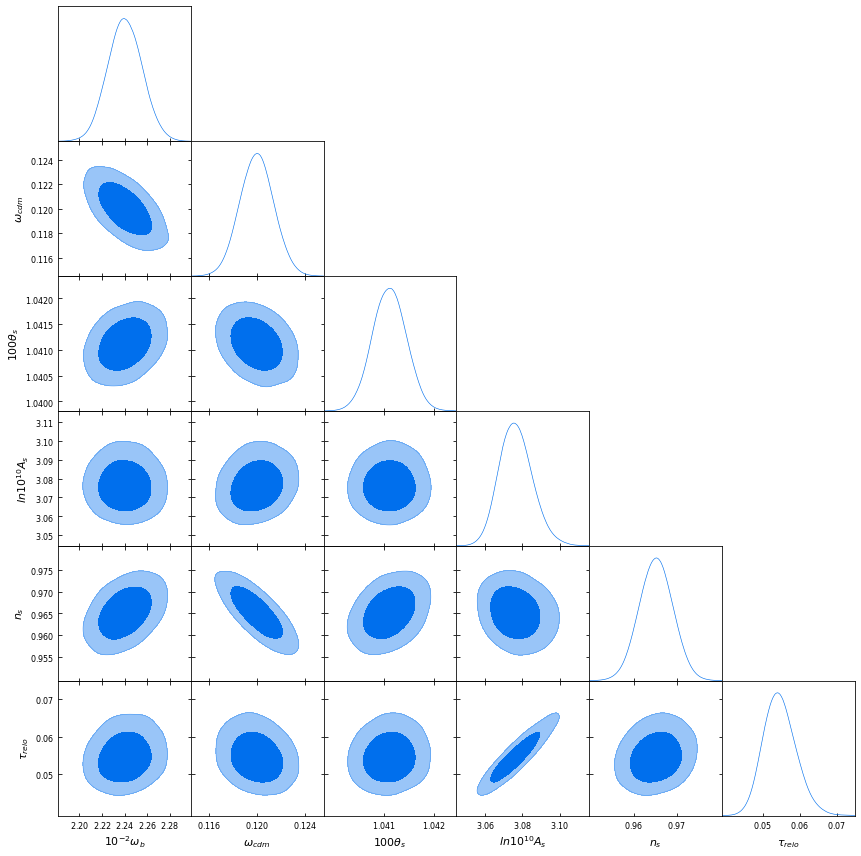

In [375]:
logger.setLevel(logging.INFO)
g = plots.get_subplot_plotter()
g.triangle_plot([sampMC], filled=True)

In [376]:
import os
import copy
import matplotlib
import sys
import warnings
import logging
from types import MappingProxyType
from typing import Mapping, Sequence, Union

if 'ipykern' not in matplotlib.rcParams['backend'] and \
        'linux' in sys.platform and os.environ.get('DISPLAY', '') == '':
    # default to agg if not in notebook and linux with no display
    matplotlib.use('Agg')

import matplotlib.patches
import matplotlib.colors
import matplotlib.gridspec
import matplotlib.axis
import matplotlib.lines
from matplotlib import cm, rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.font_manager import font_scalings
import numpy as np
import getdist
from getdist import MCSamples, loadMCSamples, ParamNames, ParamInfo, IniFile
from getdist.chain_grid import is_grid_object, get_chain_root_files, ChainDirGrid, load_supported_grid
from getdist.chains import findChainFileRoot
from getdist.paramnames import escapeLatex, makeList, mergeRenames
from getdist.densities import Density2D
from getdist.gaussian_mixtures import MixtureND
from getdist.matplotlib_ext import BoundedMaxNLocator, SciFuncFormatter
from getdist._base import _BaseObject

In [388]:
'''hack to allow different weights per plot'''
def triangle_plot(self, roots,weights=None, params=None, legend_labels=None, plot_3d_with_param=None, filled=False, shaded=False,
                      contour_args=None, contour_colors=None, contour_ls=None, contour_lws=None, line_args=None,
                      label_order=None, legend_ncol=None, legend_loc=None, title_limit=None, upper_roots=None,
                      upper_kwargs={}, upper_label_right=False, diag1d_kwargs={}, markers=None,
                      marker_args={}, param_limits={}, **kwargs):
        
        roots = makeList(roots)
        params = self.get_param_array(roots[0], params)
        plot_col = len(params)
        if plot_3d_with_param is not None:
            col_param = self._check_param(roots[0], plot_3d_with_param)
        self.make_figure(nx=plot_col, ny=plot_col, sharex=self.settings.no_triangle_axis_labels,
                         sharey=self.settings.no_triangle_axis_labels)
        lims = dict()
        if kwargs.pop('filled_compare', False):
            filled = True

        def _axis_y_limit_changed(_ax):
            _lims = _ax.get_ylim()
            other = _ax._shared_x_axis
            if _lims != other.get_xlim():
                other.set_xlim(_lims)

        def _axis_x_limit_changed(_ax):
            _lims = _ax.get_xlim()
            other = _ax._shared_y_axis
            if _lims != other.get_ylim():
                other.set_ylim(_lims)

        def def_line_args(cont_args, cont_colors):
            cols = []
            for plotno, _arg in enumerate(cont_args):
                if not _arg.get('filled'):
                    if cont_colors is not None and len(cont_colors) > plotno:
                        cols.append(cont_colors[plotno])
                    else:
                        cols.append(None)
                else:
                    cols.append(_arg.get('color') or self._get_color_at_index(self.settings.solid_colors,
                                                                              len(cont_args) - plotno - 1))
            _line_args = []
            for col in cols:
                if col is None:
                    _line_args.append({})
                else:
                    if isinstance(col, (tuple, list)) and not matplotlib.colors.is_color_like(col):
                        col = col[-1]
                    _line_args += [{'color': col}]
            return _line_args

        if upper_roots is not None:
            if plot_3d_with_param is not None:
                logging.warning("triangle_plot upper_roots currently doesn't work with plot_3d_with_param")
            upper_contour_args = self._make_contour_args(len(upper_roots), filled=upper_kwargs.get('filled', filled),
                                                         contour_args=upper_kwargs.get('contour_args', contour_args),
                                                         colors=upper_kwargs.get('contour_colors', contour_colors),
                                                         ls=upper_kwargs.get('contour_ls', contour_ls),
                                                         lws=upper_kwargs.get('contour_lws', contour_lws))
            upper_line_args = upper_kwargs.get('line_args') or def_line_args(upper_contour_args,
                                                                             upper_kwargs.get('contour_colors',
                                                                                              contour_colors))
            upargs = self._make_line_args(len(upper_roots), line_args=upper_line_args,
                                          ls=upper_kwargs.get('contour_ls', contour_ls),
                                          lws=upper_kwargs.get('contour_lws', contour_lws))

        contour_args = self._make_contour_args(len(roots), filled=filled, contour_args=contour_args,
                                               colors=contour_colors, ls=contour_ls, lws=contour_lws)
        if line_args is None:
            line_args = def_line_args(contour_args, contour_colors)
        line_args = self._make_line_args(len(roots), line_args=line_args, ls=contour_ls, lws=contour_lws)
        roots1d = copy.copy(roots)
        if upper_roots is not None:
            show_1d = upper_kwargs.get('show_1d', True)
            if isinstance(show_1d, bool):
                show_1d = [show_1d] * len(upargs)
            for root, arg, show in zip(upper_roots, upargs, show_1d):
                if show and root not in roots1d:
                    roots1d.append(root)
                    line_args.append(arg)

        bottom = len(params) - 1
        for i, param in enumerate(params):
            for i2 in range(bottom, i, -1):
                self._subplot(i, i2, pars=(param, params[i2]),
                              sharex=self.subplots[bottom, i] if i2 != bottom else None,
                              sharey=self.subplots[i2, 0] if i > 0 else None)

            ax = self._subplot(i, i, pars=(param,), sharex=self.subplots[bottom, i] if i != bottom else None)
            marker = self._get_marker(markers, i, param.name)
            self._inner_ticks(ax, False)
            xlim = self.plot_1d(roots1d+[MCSamples(samples=samples['params'], names=names,
                                                    weights=samples['weights'][(i,)])],
                                param, marker=marker, do_xlabel=i == plot_col - 1,
                                no_label_no_numbers=self.settings.no_triangle_axis_labels, title_limit=title_limit,
                                label_right=True, no_zero=True, no_ylabel=True, no_ytick=True, line_args=line_args,
                                lims=param_limits.get(param.name), ax=ax, _ret_range=True, **diag1d_kwargs)
            lims[i] = xlim
            if i > 0:
                ax._shared_y_axis = self.subplots[i, 0]
                ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

        if upper_roots is not None:
            if not upper_label_right:
                # make label on first 1D plot appropriate for 2D plots in rest of row
                label_ax = self.subplots[0, 0].twinx()
                self._inner_ticks(label_ax)
                label_ax.yaxis.tick_left()
                label_ax.yaxis.set_label_position('left')
                label_ax.yaxis.set_offset_position('left')
                label_ax.set_ylim(lims[0])
                self.set_ylabel(params[0], ax=label_ax)
                self._set_main_axis_properties(label_ax.yaxis, False)
                self.subplots[0, 0].yaxis.set_visible(False)
            else:
                label_ax = self.subplots[0, bottom]

            for y, param in enumerate(params[:-1]):
                for x in range(bottom, y, -1):
                    if y > 0:
                        share = self.subplots[y, 0]
                    else:
                        share = label_ax if (y < bottom or not upper_label_right) else None
                    self._subplot(x, y, pars=(params[x], param), sharex=self.subplots[bottom, x], sharey=share)

        for i, param in enumerate(params):
            marker = self._get_marker(markers, i, param.name)
            for i2 in range(i + 1, len(params)):
                param2 = params[i2]
                pair = [param, param2]
                marker2 = self._get_marker(markers, i2, param2.name)
                ax = self.subplots[i2, i]
                if plot_3d_with_param is not None:
                    self.plot_3d(roots, pair + [col_param], color_bar=False, line_offset=1, add_legend_proxy=False,
                                 do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0, contour_args=contour_args,
                                 no_label_no_numbers=self.settings.no_triangle_axis_labels, ax=ax, **kwargs)
                else:
                    self.plot_2d(roots+[MCSamples(samples=samples['params'], names=names,
                                                    weights=samples['weights'][(i,i2)])],
                                 param_pair=pair, do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0,
                                 no_label_no_numbers=self.settings.no_triangle_axis_labels, shaded=shaded,
                                 add_legend_proxy=i == 0 and i2 == 1, contour_args=contour_args, ax=ax, **kwargs)
                if marker is not None:
                    self.add_x_marker(marker, ax=ax, **marker_args)
                if marker2 is not None:
                    self.add_y_marker(marker2, ax=ax, **marker_args)
                self._inner_ticks(ax)
                if i != i2:
                    ax.set_ylim(lims[i2])

                ax._shared_x_axis = self.subplots[bottom, i2]
                ax.callbacks.connect('ylim_changed', _axis_y_limit_changed)

                if i2 == bottom:
                    ax.set_xlim(lims[i])
                if i > 0:
                    ax._shared_y_axis = self.subplots[i, 0]
                    ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

                if upper_roots is not None:
                    if i == 0:
                        ax._shared_y_axis = label_ax
                        ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

                    ax = self.subplots[i, i2]
                    pair.reverse()
                    if plot_3d_with_param is not None:
                        self.plot_3d(upper_roots, pair + [col_param], color_bar=False, line_offset=1,
                                     add_legend_proxy=False, ax=ax, do_xlabel=False,
                                     do_ylabel=upper_label_right and i2 == bottom, contour_args=upper_contour_args,
                                     no_label_no_numbers=self.settings.no_triangle_axis_labels)
                    else:
                        self.plot_2d(upper_roots, param_pair=pair, do_xlabel=False,
                                     do_ylabel=upper_label_right and i2 == bottom,
                                     no_label_no_numbers=self.settings.no_triangle_axis_labels, shaded=shaded,
                                     add_legend_proxy=i == 0 and i2 == 1, ax=ax,
                                     proxy_root_exclude=[root for root in upper_roots if root in roots],
                                     contour_args=upper_contour_args)
                    if marker is not None:
                        self.add_y_marker(marker, ax=ax, **marker_args)
                    if marker2 is not None:
                        self.add_x_marker(marker2, ax=ax, **marker_args)
                    if upper_label_right and i2 == bottom:
                        ax.yaxis.set_label_position('right')
                        ax.yaxis.set_offset_position('right')
                        ax.yaxis.set_tick_params(which='both', labelright=True, labelleft=False)
                        self.set_ylabel(params[i], ax=ax, rotation=-90, va='bottom')

                    ax.set_xlim(lims[i2])
                    ax.set_ylim(lims[i])
                    ax._shared_x_axis = self.subplots[bottom, i]
                    ax.callbacks.connect('ylim_changed', _axis_y_limit_changed)
                    self._inner_ticks(ax)

        self._subplots_adjust()

        if plot_3d_with_param is not None:
            bottom = 0.5
            if len(params) == 2:
                bottom += 0.1
            cb = self.fig.colorbar(self.last_scatter, cax=self.fig.add_axes([0.9, bottom, 0.03, 0.35]))
            cb.ax.yaxis.set_ticks_position('left')
            cb.ax.yaxis.set_label_position('left')
            self.rotate_yticklabels(cb.ax, rotation=self.settings.colorbar_tick_rotation or 0,
                                    labelsize=self.settings.colorbar_axes_fontsize)
            self.add_colorbar_label(cb, col_param, label_rotation=-self.settings.colorbar_label_rotation)

        labels = self._default_legend_labels(legend_labels, roots1d)

        if not legend_loc and self.settings.figure_legend_loc == 'upper center' and \
                len(params) < 4 and upper_roots is None:
            legend_loc = 'upper right'
        else:
            legend_loc = legend_loc or self.settings.figure_legend_loc
        args = {}
        if 'upper' in legend_loc and upper_roots is None:
            args['bbox_to_anchor'] = (self.plot_col / (2 if 'center' in legend_loc else 1), 1)
            args['bbox_transform'] = self.subplots[0, 0].transAxes
            args['borderaxespad'] = 0

        self.finish_plot(labels, label_order=label_order,
                         legend_ncol=legend_ncol or self.settings.figure_legend_ncol or (
                             None if upper_roots is None else len(labels)), legend_loc=legend_loc,
                         no_extra_legend_space=upper_roots is None, no_tight=title_limit or self.settings.title_limit,
                         **args)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


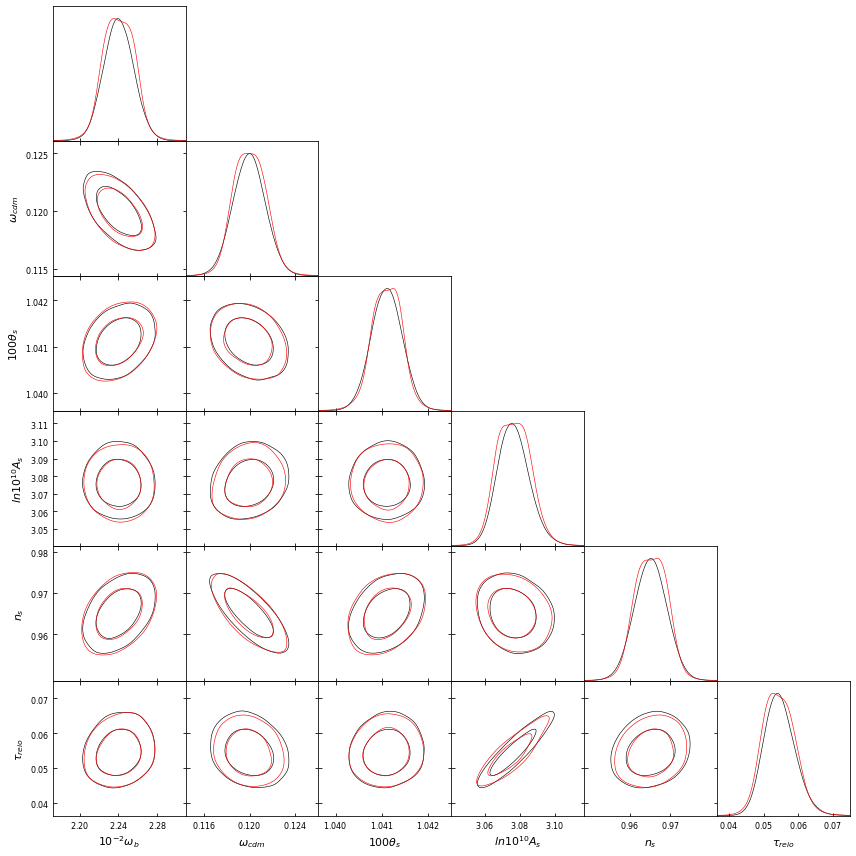

In [390]:
triangle_plot(g,[sampMC], filled=False)